In [27]:
import argparse
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


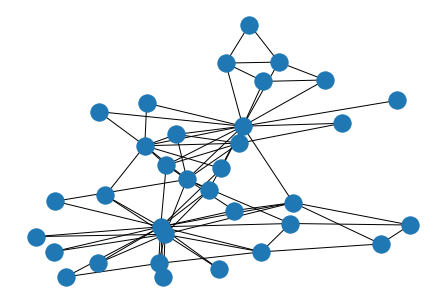

In [3]:
# graph data file
fp = '../data/karate.edgelist'

G = nx.read_edgelist(path=fp, delimiter=' ')

for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

nx.draw(G)
plt.show()

In [8]:
# generate
def alias_generate(p):

    smaller, bigger = [], []
    n = len(p)

    K = [n * pi for pi in p]
    U = [0] * n

    for ind, item in enumerate(K):
        if item < 1:
            smaller.append(ind)
        else:
            bigger.append(ind)

    while smaller and bigger:
        small_ind = smaller[0]
        big_ind = bigger[0]
        U[small_ind] = big_ind
        K[big_ind] = K[big_ind] - (1. - K[small_ind])
        if K[big_ind] < 1.:
            bigger.pop(0)
            smaller.append(big_ind)
        smaller.pop(0)
    return K, U

def alias_sample(K, U):
    n = len(K)
    x = np.random.rand()
    i = int(np.floor(n * x))

    if np.random.rand() < K[i]:
        return i
    else:
        return U[i]


In [24]:
class Graph():
    def __init__(self, NXGraph, p, q):
        self.G = NXGraph
        self.p = p
        self.q = q
        self.alias_node_parm = None
        self.alias_edge_param = None
        
        
    def random_walk(self, src, lenght):
        walk = [src]
        
        for _ in range(lenght - 1):
            curr = walk[-1]
            nbrs = list(self.G.neighbors(curr))
            if nbrs:
                if len(walk) == 1:
                    walk.append(nbrs[alias_sample(self.alias_node_parm[curr][0], self.alias_node_parm[curr][1])])
                else:
                    prev = walk[-2]
                    next_node = nbrs[alias_sample(self.alias_edge_param[(prev, curr)][0], 
                                                    self.alias_edge_param[(prev, curr)][1])]
                    walk.append(next_node)                    
            else:
                break
        
        return walk
    
    
    def simulate(self, num_walks, length):
        walks = []
        nodes = list(self.G.nodes())
        
        for _ in range(num_walks):
            np.random.shuffle(nodes)
            for node in nodes:
                walks.append(self.random_walk(node, length))
                
        return walks
        
    
    def get_alias_edge(self, src, dst):
        neigh_weights = []
        for dst_neig in list(self.G.neighbors(dst)):
            if dst_neig == src:
                neigh_weights.append(G[dst][dst_neig]['weight'] / self.p)
            elif self.G.has_edge(dst_neig, src):
                neigh_weights.append(G[dst][dst_neig]['weight'])
            else:
                neigh_weights.append(G[dst][dst_neig]['weight'] / self.q)
        
        norm_constant = sum(neigh_weights)
        norm_weights = [float(w)/norm_constant for w in neigh_weights]
        
        return alias_generate(norm_weights)
                
    
    
    def build_transition_probs(self):
        
        alias_node_parm = {}
        alias_edge_param = {}
        
        for node in G.nodes():
            neigh_weights = [G[node][i]['weight'] for i in G.neighbors(node)]
            norm_constant = sum(neigh_weights)
            norm_weights = [float(w)/norm_constant for w in neigh_weights]
            alias_node_parm[node] = alias_generate(norm_weights)
            
        self.alias_node_parm = alias_node_parm
        
        for edge in G.edges():
            alias_edge_param[edge] = self.get_alias_edge(edge[0], edge[1])
            alias_edge_param[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
            
        self.alias_edge_param = alias_edge_param


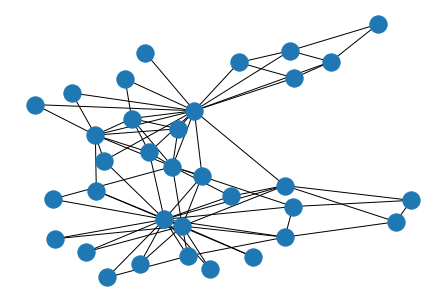

In [22]:
# graph data file
fp = '../data/karate.edgelist'

Gnx = nx.read_edgelist(path=fp, delimiter=' ')

for edge in Gnx.edges():
    Gnx[edge[0]][edge[1]]['weight'] = 1

nx.draw(G)
plt.show()

In [ ]:
graph = Graph(Gnx, 1, 1)
graph.build_transition_probs()
walks = graph.simulate(64, 16)

In [60]:
# convert walks to ints
data = torch.zeros(len(walks), 16, dtype=torch.long)
for i, walk in enumerate(walks):
    data[i] = torch.tensor([int(x) for x in walk])

In [70]:
class EmbeddModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddModel, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        
    def forward(self, x):
        return self.embedding(x)

In [72]:
vocab_size = len(np.unique(data.numpy().ravel())) + 1
print(vocab_size)
embedding_dim = 2

# Model
model = EmbeddModel(vocab_size, embedding_dim)
optimizer = SGD(model.parameters(), lr=0.001)

for _ in range(10):
    # split data into start/head tokens and rest/tail of the sentence
    head = data[:, 0]
    tail = data[:, 1:].contiguous()
    
    # embedding forward
    head_em = model(head).view(data.size(0), 1, embedding_dim)
    tail_em = model(tail.view(-1)).view(data.size(0), tail.size(1), embedding_dim)
    
    pos_out = (head_em * tail_em).sum(dim=-1).view(-1)
    
    poss_loss = -torch.log(torch.sigmoid(pos_out) + 1e-6).mean()
    
    # Negative sampling loss
    neg_samples = torch.randint(vocab_size, (data.size(0), tail.size(1)), dtype=torch.long)
    
    neg_em = model(neg_samples)
    
    neg_out = (head_em * neg_em).sum(dim=-1).view(-1)
    
    neg_loss = -torch.log(1 - torch.sigmoid(neg_out) + 1e-6).mean()
    
    total_loss = poss_loss + neg_loss
    
    model.zero_grad()
    total_loss.backward()
    optimizer.step()

35


In [39]:
len(walks[0])

16

34